# Plots by Sebastian
## Plotting genres part of movies pr. year

### Importing libraries

In [1]:
import matplotlib.pyplot as plt 
from data_gen import gen_df
import numpy as np
import ipywidgets as widgets
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

### Generating dataframe from data-file

In [2]:
filename = 'imdb.csv'

df = gen_df(filename)
df['year'] = df['year'].astype(int)
df.head()

,index,tid,title,imdbRating,ratingCount,duration,year,nrOfWins,nrOfNominations,nrOfPhotos,...,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western,decade
0,2200,tt0011565,The Penalty (1920),7.6,1095.0,1.500000,1920,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1920s
1,502,tt0011841,MÌ_dchenlos (1920),8.1,3134.0,2.416667,1920,0.0,0.0,18.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1920s
2,12832,tt0011865,Irrwege einer Ehe (1920),8.2,1042.0,1.500000,1920,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1920s
3,12148,tt0010323,Das Cabinet des Dr. Caligari (1920),8.1,29379.0,1.300000,1920,0.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1920s
4,12368,tt0011071,Buster Keaton als StrÌ_fling (1920),7.1,1474.0,0.333333,1920,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1920s


### Plotting genres as part of total movies at the year
These are generated as:
$$
\text{Genre share} = \frac{\text{Total movies in genre in year}}{\text{Total movies in year}}
$$

In [3]:
# Generate genre list
genre_list = list(df)[13:41]

In [146]:
def genre_share_fig():

    def _plot_1(df,genre):

        df['count'] = 1
        df['movies_year'] = df.groupby('year')['count'].transform(lambda x: x.sum())  

        # Plot year sum of different genres
        for i in genre:
        #i = genre

            df[f'{i}_year'] = df.groupby('year')[i].transform(lambda x: x.sum())
            df[f'{i}_share'] = df[f'{i}_year']/df['movies_year']

            y_share = df.groupby('year')[f'{i}_share'].first()

            #ax = plt.subplot(2,2,j)
            y_share.plot(kind='line', sharex='col', sharey='row')

            plt.xlabel('year')
            plt.ylabel('share of movies')
            plt.title(i)

        #plt.show()

    def plot_1(df):

        widgets.interact(_plot_1,
                        df = widgets.fixed(df),
                        genre = widgets.SelectMultiple(
                            options = genre_list,
                            description = 'Genres',
                            disabled = False))

    plot_1(df)

genre_share_fig()

interactive(children=(SelectMultiple(description='Genres', options=('Action', 'Adult', 'Adventure', 'Animation…

## Listing top/bottom 5 movies per decade and finding their original titles from IMDb
To do this we sort the datasets on imdbRating and select top 5 and bottom 5 from each decade. From this we pull out the id's, and use these to find original titles from IMDb. This is done by using the request-module, which acceses the IMDb-website and finds the title.

In [147]:
def find_orgnames():

    # Condition on minimum number of ratings
    I = df['ratingCount'] >= 5000

    # Sort top and bottom movies by decade
    top = df.sort_values(['decade', 'imdbRating'], ascending=False)[I];
    top5_decade = top.groupby('decade').head(5)
    bottom = df.sort_values(['decade', 'imdbRating'], ascending=True)[I];
    bottom5_decade = bottom.groupby('decade').head(5)

    # Get IMDb id's
    top5_id = top5_decade.tid.tolist()
    bottom5_id = bottom5_decade.tid.tolist()
    id5_list = top5_id + bottom5_id 

    # Initiate list to get names from IMDb
    org_names = []

    # Get original names from IMDb using requests
    for i,id in enumerate(id5_list):
        test = requests.get('https://www.imdb.com/title/' + id)
        soup = bs(test.text,'html.parser')
        if soup.find('div',class_='originalTitle') != None:
            org_names.append(soup.find('div',class_='originalTitle').text)
        else:
            org_names.append(soup.find('h1').text)
            
    return org_names

In [149]:
def top_bottom_list():

    # Runs function, which finds original names by requests
    org_names = find_orgnames()
    
    # Merge original names with data
    df_merge_1 = pd.DataFrame(i for i in org_names) # Names
    df_merge_2 = pd.DataFrame(i for i in id5_list) # ID
    df_merge = df_merge_1.merge(df_merge_2, left_index=True, right_index=True) # Set names and ID together
    df_merge = df_merge.rename(columns={'0_x': 'org_title', '0_y': 'tid'}) # Rename for merge

    text = ''

    # Merge with data
    top_bottom = df.merge(df_merge, how='inner', on='tid')
    top_bottom['org_title'] = top_bottom['org_title'].str.split('\(').str[0] # Remove parenthesis with years
    grouped = top_bottom[['org_title','imdbRating','decade']].sort_values('imdbRating', ascending=False).reset_index(drop=True).groupby('decade')

    # Prints solution
    for name, group in grouped:
        text += '\n\n'
        text += f'The top 5 movies of the {name} are: '
        name_list = group.org_title.tolist()
        rating_list = group.imdbRating.tolist()
        for j,i in enumerate(name_list):
            if j < 5:
                text += '\n'
                text += f'{i:<40} with rating: {rating_list[j]}'
            if j == 5:
                text += '\n\n'
                text += f'The bottom 5 movies of the {name} are: \n'
                text += f'{i:<40} with rating: {rating_list[j]}'
            if j > 5:
                text += '\n'
                text += f'{i:<40} with rating: {rating_list[j]}'   

    print(text)
    
top_bottom_list()

c:\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
c:\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':




The top 5 movies of the 1920s are: 
The Kid                                  with rating: 8.4
Chelovek s kino-apparatom                with rating: 8.4
Sunrise: A Song of Two Humans            with rating: 8.4
Metropolis                               with rating: 8.4
Safety Last!                             with rating: 8.3

The bottom 5 movies of the 1920s are: 
Greed                                    with rating: 7.8
Nanook of the North                      with rating: 7.8
The Lodger: A Story of the London Fog    with rating: 7.4
Blackmail                                with rating: 7.1
The Jazz Singer                          with rating: 6.9

The top 5 movies of the 1930s are: 
City Lights                              with rating: 8.7
Modern Times                             with rating: 8.6
M - Eine Stadt sucht einen Mörder        with rating: 8.5
Mr. Smith Goes to Washington             with rating: 8.4
It Happened One Night                    with rating: 8.3

The bottom 5 m

## Counting number of newsarticles and movies per decade, and newsarticles relative to \# of movies 

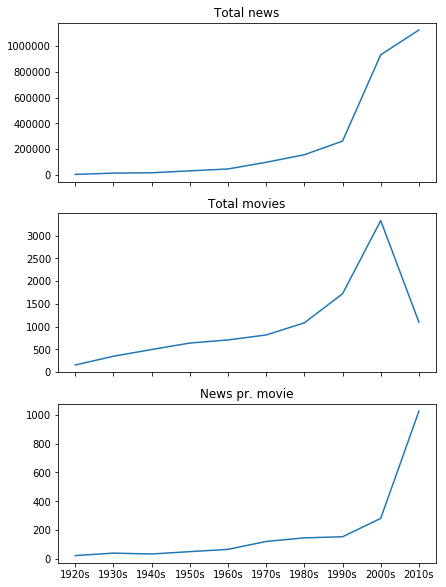

In [108]:
def news_pr_movie_fig():

    df['dummy'] = 1

    # Count number of news articles
    def total_news(x):
        d = x['nrOfNewsArticles'].sum()
        return pd.Series(d, index = ['Total number of news'])

    # Count number of movies
    def total_movies(x):
        d = x['dummy'].sum()
        return pd.Series(d, index = ['Total number of movies'])

    # Find news pr. movie
    def news_pr_movie(x):
        d = np.array(x['nrOfNewsArticles'].sum()/x['dummy'].sum())
        return pd.Series(d, index = ['news Pr Movie'])

    # Variables for plots
    x = df.groupby('decade').apply(total_news)
    z = df.groupby('decade').apply(news_pr_movie)
    y = df.groupby('decade').apply(total_movies)

    # Start subplot
    f, (fig1,fig2,fig3) = plt.subplots(3,1,sharex=True)
    f.subplots_adjust(hspace=0.2,right=1,top=2)

    # Plot the data
    fig1.plot(x)
    fig1.set_title('Total news')
    fig2.plot(y)
    fig2.set_title('Total movies')
    fig3.plot(z)
    fig3.set_title('News pr. movie');

news_pr_movie_fig()


## Finding correlation between newsarticles and rating

In [145]:
def corr_pr_decade():
    
    text = 'Correlation between award wins and news articles: \n'
    text += 'For all years: \n'
    text += str(round(df[['imdbRating','nrOfNewsArticles']].corr().iloc[0,1],3))
    
    
    for i in df.decade.unique():
    
        I = df['decade'] == i
        df_temp = df[I]
        
        text += '\n\n'
        text += f'For {i}: \n'
        text += str(round(df_temp[['imdbRating','nrOfNewsArticles']].corr().iloc[0,1],3))
        
    print(text)

corr_pr_decade()


Correlation between award wins and news articles: 
For all years: 
0.091

For 1920s: 
0.185

For 1930s: 
0.189

For 1940s: 
0.348

For 1950s: 
0.221

For 1960s: 
0.218

For 1970s: 
0.117

For 1980s: 
0.23

For 1990s: 
0.229

For 2000s: 
0.127

For 2010s: 
0.161
